# A Primer on Bayesian Multilevel Modeling using PyStan

*Author*: Chris Fonnesbeck  
*License*: Apache, Version 2.0 (code); CC-BY 3.0 (text)

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 

* e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

We will motivate this topic using an environmental epidemiology example.

### Example: Radon contamination (Gelman and Hill 2006)

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](http://www.fix-your-radon.com/images/how_radon_enters.jpg)

The EPA did a study of radon levels in 80,000 houses. Two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota.

The hierarchy in this example is households within county. 

### Data organization

First, we import the data from a local file, and extract Minnesota's data.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_columns = None

import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

# Import radon data
srrs2 = pd.read_csv('../data/srrs2.dat')
srrs2.columns = srrs2.columns.map(str.strip) # clean up headers

# make a unique id from stateid and countyid - pretty much a hash fn. Then restrict the state to just MN
# fips is used to merge the data with county data later
srrs_mn = srrs2.assign(fips=srrs2.stfips*1000 + srrs2.cntyfips)[srrs2.state=='MN']

In [2]:
# some stats about the feeling of the data

# print(srrs_mn.count(), srrs2.count(), srrs2.size) # number of datapoints per row. samples
print(srrs_mn.columns)
print(srrs_mn.shape)
print(srrs_mn.head())


Index([u'idnum', u'state', u'state2', u'stfips', u'zip', u'region',
       u'typebldg', u'floor', u'room', u'basement', u'windoor', u'rep',
       u'stratum', u'wave', u'starttm', u'stoptm', u'startdt', u'stopdt',
       u'activity', u'pcterr', u'adjwt', u'dupflag', u'zipflag', u'cntyfips',
       u'county', u'fips'],
      dtype='object')
(919, 26)
      idnum state state2  stfips    zip  region  typebldg  floor  room  \
5080   5081    MN     MN      27  55735       5         1      1     3   
5081   5082    MN     MN      27  55748       5         1      0     4   
5082   5083    MN     MN      27  55748       5         1      0     4   
5083   5084    MN     MN      27  56469       5         1      0     4   
5084   5085    MN     MN      27  55011       3         1      0     4   

     basement windoor rep  stratum wave  starttm  stoptm  startdt  stopdt  \
5080        N           2        4   41      930     930    12088   12288   
5081        Y           5        2   40     1615 

Next, obtain the county-level predictor, uranium, by combining two variables.

In [3]:
cty = pd.read_csv('../data/cty.dat') # this is city level data
cty_mn = cty[cty.st=='MN'].copy()    # care about minesota only
cty_mn['fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

# some stats that we care about:
print(cty_mn.shape)
print(cty_mn.head(2))

# Uppm is the Uranium level at counties

(89, 8)
      stfips  ctfips  st     cty     lon     lat      Uppm   fips
1326      27       1  MN  AITKIN -93.415  46.608  0.502054  27001
1327      27       3  MN   ANOKA -93.246  45.273  0.428565  27003


Use the `merge` method to combine home- and county-level information in a single DataFrame.

In [4]:
srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm)

n = len(srrs_mn)

In [5]:
# This is the data we deal with. Hierarchy is defined by county. target var is 'activity'
srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,floor,room,basement,windoor,rep,stratum,wave,starttm,stoptm,startdt,stopdt,activity,pcterr,adjwt,dupflag,zipflag,cntyfips,county,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,,2,4,41,930,930,12088,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,,5,2,40,1615,1615,11888,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,,3,2,42,1030,1515,20288,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,,2,2,24,1410,1410,122987,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,,3,2,40,600,600,12888,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


We also need a lookup table (`dict`) for each unique county, for indexing.

In [ ]:
srrs_mn.county = srrs_mn.county.str.strip()
mn_counties = srrs_mn.county.unique()
county_lookup = dict(zip(mn_counties, range(len(mn_counties))))
county_lookup

Finally, create local copies of variables.

In [89]:
counties = srrs_mn['county_code'] = srrs_mn.county.replace(county_lookup).values # make a new column for county code
radon = srrs_mn.activity # this is the actual activity measured
srrs_mn['log_radon'] = log_radon = np.log(radon + 0.1).values # convert activity(radon) to log_radon 
floor_measure = srrs_mn.floor.values # which floor we did the calculation on

Distribution of radon levels in MN (log scale):

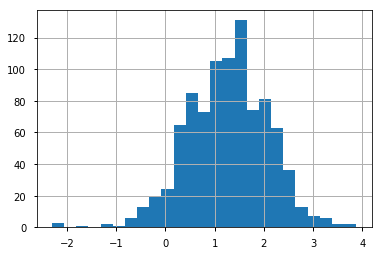

In [90]:
srrs_mn.activity.apply(lambda x: np.log(x+0.1)).hist(bins=25)

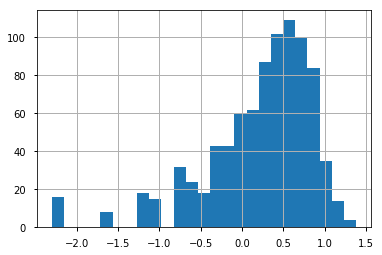

In [91]:
srrs_mn.log_radon.apply(lambda x: np.log(x+0.1)).hist(bins=25)

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

To specify this model in Stan, we begin by constructing the `data` block, which includes vectors of log-radon measurements (`y`) and floor measurement covariates (`x`), as well as the number of samples (`N`).

In [66]:
pooled_data = """
data {
  int<lower=0> N; 
  vector[N] x;
  vector[N] y;
}
"""

Next we initialize our parameters, which in this case are the linear model coefficients and the normal scale parameter. Notice that `sigma` is constrained to be positive.

In [67]:
pooled_parameters = """
parameters {
  vector[2] beta;
  real<lower=0> sigma;
} 
"""

Finally, we model the log-radon measurements as a normal sample with a mean that is a function of the floor measurement.

In [68]:
pooled_model = """
model {
  y ~ normal(beta[1] + beta[2] * x, sigma);
}
"""

We then pass the code, data, and parameters to the `stan` function. The sampling requires specifying how many iterations we want, and how many parallel chains to sample. Here, we will sample 2 chains of length 1000.

In [69]:
import pystan
# regressing log_radon on which floor we did the measurements on
pooled_data_dict = {'N': len(log_radon),
                    'x': floor_measure,
                    'y': log_radon}

pooled_fit = pystan.stan(
    model_code=pooled_data + pooled_parameters + pooled_model, # model_code is just a string
    data=pooled_data_dict, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_dd6a876b770652d53bdcc0546345af4b NOW.


The sample can be extracted for plotting and summarization.

In [70]:
pooled_sample = pooled_fit.extract(permuted=True) # of type OrderedDict
# dir(pooled_sample)
# type(pooled_sample)
# what output we get out of Stan then?
pooled_sample.keys()     # you get out your params and lp__

[u'beta', u'sigma', u'lp__']

In [71]:
# lp__ are explained here:
# lp__ terms are explained here: https://www.jax.org/news-and-insights/jax-blog/2015/october/lp-in-stan-output#
# and here:  http://andrewgelman.com/2015/10/03/comparing-waic-or-loo-or-any-other-predictive-error-measure/

In [72]:
# for beta, we can get the sampling distribution of both the first and second beta[i]
print(pooled_sample['beta'].shape)
print(pooled_sample['beta'][:5,:]) # sample some rows
b0, m0 = pooled_sample['beta'].T.mean(axis=1)  # get the mean of the estimated params to interp
print(b0, m0) # b0 is intercept, m0 is the coefficients

(1000, 2)
[[ 1.33256149 -0.55891237]
 [ 1.39162374 -0.47560748]
 [ 1.34072921 -0.54933282]
 [ 1.39680479 -0.6228194 ]
 [ 1.36024044 -0.59727852]]
(1.3639494830635617, -0.5872902413526268)


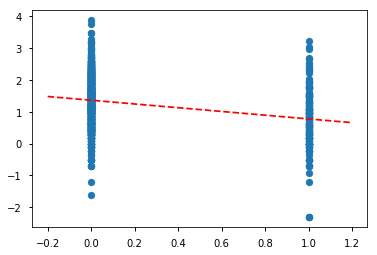

In [73]:
plt.scatter(srrs_mn.floor, np.log(srrs_mn.activity+0.1))
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, m0*xvals+b0, 'r--')

At the other end of the extreme, we can fit separate (independent) means for each county. The only things that are shared in this model are the coefficient for the basement measurement effect, and the standard deviation of the error.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

In [74]:
# you can make the model code as a long string:
un_p_data = """
data {
  int<lower=0> N; 
  int<lower=1,upper=85> county[N];  // range of the counties, can't use String here
  vector[N] x;
  vector[N] y;
}"""

# bound the value of sigma, expect a(alpha) to be a vector of 85
un_p_params = """
parameters {
  vector[85] a;  
  real beta;
  real<lower=0,upper=100> sigma;
}"""

# for each sample, the outcome is a linear function of basement measurement effect + the associated counties' measurement
transformed_params = """
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- beta * x[i] + a[county[i]];
}"""

# the model assume sigma noise around y_hat, and all noise shares sigma as the same params
un_p_model = """
model {
  y ~ normal(y_hat, sigma);
}"""

unpooled_model = un_p_data + un_p_params + transformed_params + un_p_model

In [92]:
# the order and type of 
unpooled_data = {'N': len(log_radon),
                 'county': counties+1,   # Stan counts starting at 1, so we need to add one to all the countyID
                 'x': floor_measure,
                 'y': log_radon}

unpooled_fit = pystan.stan(model_code=unpooled_model, data=unpooled_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_616b3db8a87e1e5236e6225ad5e330a6 NOW.


In [76]:
# examine the outputs
print(type(unpooled_fit))  # proprietary type!

# what about this extraction? - it turns the result from that proprietary object to an OrderedDict
unpooled_sample = unpooled_fit.extract(permuted=True) # of type OrderedDict
print(unpooled_sample.keys())  # 
print(unpooled_fit['a'].shape, unpooled_sample['a'].shape)

# turns out that the two objects unpooled_fit and unpooled_sample contains more or less the same data:
print(np.max(unpooled_fit['a'] - unpooled_sample['a']), np.max(unpooled_fit['beta'] - unpooled_sample['beta']))

# interestingly, you get y_hat as well!
print(unpooled_sample['y_hat'].shape)

<type 'stanfit4anon_model_616b3db8a87e1e5236e6225ad5e330a6_8825330197303790895.StanFit4Model'>
[u'a', u'beta', u'sigma', u'y_hat', u'lp__']
((1000, 85), (1000, 85))
(0.0, 0.0)
(1000, 919)


In [77]:
# get the unpooled estimates and standard errors for each counties
unpooled_estimates = pd.Series(unpooled_fit['a'].mean(0), index=mn_counties)
unpooled_se = pd.Series(unpooled_fit['a'].std(0), index=mn_counties)
# print(unpooled_estimates, unpooled_se)
print(unpooled_estimates.shape, unpooled_se.shape)

((85,), (85,))


We can plot the ordered estimates to identify counties with high radon levels:

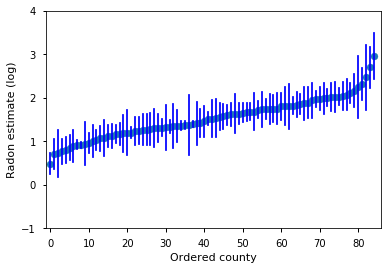

In [78]:
counties_ordered_by_a = unpooled_estimates.sort_values().index 
plt.scatter(range(len(unpooled_estimates)), unpooled_estimates[counties_ordered_by_a]) # plot the means first

for i, a_county, se in zip( range(len(unpooled_estimates)), 
                            unpooled_estimates[counties_ordered_by_a], 
                            unpooled_se[counties_ordered_by_a]):
    plt.plot([i, i], [a_county-se, a_county+se], 'b-')           # plot many vertical lines representing CIs
plt.xlim(-1,86); plt.ylim(-1,4)
plt.ylabel('Radon estimate (log)'); plt.xlabel('Ordered county');

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

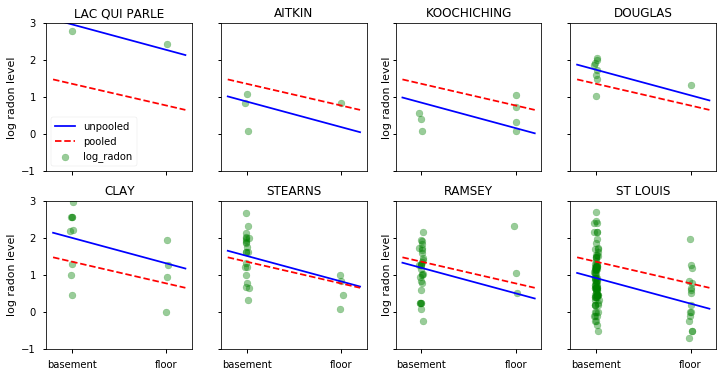

In [79]:
sample_counties =  ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel() # what does this do?
unpooled_beta = unpooled_fit['beta'].mean(0) # coef of floor (0 or 1) where we measured in the unpooled model
pooled_alpha, pooled_beta = pooled_sample['beta'].T.mean(axis=1)  # get the mean of the estimated params to interp

# one chart per county - comments on charts and change the colors for actual understanding of examples
for j, county in enumerate(sample_counties):
    y = srrs_mn.log_radon[srrs_mn.county==county]
    x = srrs_mn.floor[srrs_mn.county==county]
    axes[j].scatter(x + np.random.randn(len(x))*0.01, y, color='green', alpha=0.4) # just actual data for that county
    
    # No pooling model
    unpooled_alpha_j = unpooled_estimates[county] 
    
    # Plot both models and data
    xvals = np.linspace(-0.2, 1.2)
    axes[j].plot(xvals, unpooled_beta*xvals + unpooled_alpha_j, 'b-', label='unpooled')
    axes[j].plot(xvals, pooled_beta*xvals   + pooled_alpha, 'r--', label='pooled')
    axes[j].set_xticks([0,1])
    axes[j].set_xticklabels(['basement', 'floor'])
    axes[j].set_ylim(-1, 3)
    axes[j].set_title(county)
    if not j%2:
        axes[j].set_ylabel('log radon level')
    if j == 0:
        axes[j].legend(loc='lower left')


Notice the 'pooled' lines are exactly the same in all plots
Neither of these models are satisfactory:

* if we are trying to identify high-radon counties, pooling is useless
* we do not trust extreme unpooled estimates produced by models using few observations

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance):

![pooled](http://f.cl.ly/items/0R1W063h1h0W2M2C0S3M/Screen%20Shot%202013-10-10%20at%208.22.21%20AM.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them:

![unpooled](http://f.cl.ly/items/38020n2t2Y2b1p3t0B0e/Screen%20Shot%202013-10-10%20at%208.23.36%20AM.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***parital pooling***.

![hierarchical](http://f.cl.ly/items/1B3U223i002y3V2W3r0W/Screen%20Shot%202013-10-10%20at%208.25.05%20AM.png)

We can use PyStan to easily specify multilevel models, and fit them using Hamiltonian Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, **without any predictors** at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

- Estimates for counties with smaller sample sizes will shrink towards the state-wide average.
- Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [80]:
# same data as before - county awareness
partial_pooling_data = """
data {
  int<lower=0> N; 
  int<lower=1,upper=85> county[N];
  vector[N] y;
} """

# params: still 85 a[j] as average radon level per county to be estimated.
# these 85 a[j] comes from a distribution: N(mu_a, sigma_a)
# mu_a comes from a distribution also, but its distribution is assumed to be known.
# y_hat for any observation i is just the county level a[j] where observation y[i] belongs to. 
# y_hat[i] is the mean of the model's belief on y[i]. The model believes that y[i] follows a normal distribution
# centered around y_hat[i]
# so, does sigma_a and sigma_y got their distributions too?
partial_pooling_params = """
parameters {
  vector[85] a;
  real mu_a;
  real<lower=0, upper=100> sigma_a;
  real<lower=0, upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  for (i in 1:N)
    y_hat[i] <- a[county[i]];
}"""

# 
partial_pooling_model = """
model {
  mu_a ~ normal(0, 1);
  a ~ normal(10 * mu_a, sigma_a);
  y ~ normal(y_hat,     sigma_y);
}"""
partial_pooling = partial_pooling_data + partial_pooling_params + partial_pooling_model

Notice now we have two standard deviations, one describing the residual error of the observations, and another the variability of the county means around the average.

In [81]:
partial_pool_data = {'N': len(log_radon),
                     'county': counties+1, # Stan counts starting at 1
                     'y': log_radon}

# so if I have 2 fixed distributions for sigma_a and sigma_y, and I run 4 chains at 1000 iterations, then I ended up
# with 4000 samples, divided by 2 hyper params (sigma_a, sigma_y), so I got 2000 each. 
partial_pool_fit = pystan.stan(model_code=partial_pooling, data=partial_pool_data, iter=1000, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_c8e0453594a517d69f2b6e4879ae67e7 NOW.


In [82]:
# check out the fit results
partial_pool_samples = partial_pool_fit.extract(permuted=True)

print(partial_pool_samples.keys())

# does sigma_a and sigma_y follow distributions? - yes they have hyper params samples, that were sampled from 
# our given distributions. Each of sigma_a and sigma_y have 4*1000/2 = 2000 samples each
for k in partial_pool_samples.keys():
    print(k, partial_pool_samples[k].shape)

[u'a', u'mu_a', u'sigma_a', u'sigma_y', u'y_hat', u'lp__']
(u'a', (2000, 85))
(u'mu_a', (2000,))
(u'sigma_a', (2000,))
(u'sigma_y', (2000,))
(u'y_hat', (2000, 919))
(u'lp__', (2000,))


In [83]:
sample_trace = partial_pool_samples['a']  # retrieve the 2000x85 matrix of samples for the 85 counties' average levels 

samples, n_counties = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=n_counties) # make 85 jitters

n_county = srrs_mn.groupby('county')['idnum'].count() # number of observations by county - bad var name really
unpooled_means = srrs_mn.groupby('county')['log_radon'].mean()  # empirical means by county
unpooled_sd = srrs_mn.groupby('county')['log_radon'].std()      # std by county
unpooled = pd.DataFrame({'n': n_county, 'mean_j': unpooled_means, 'sd': unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)
unpooled.head()
# [ctrl shft -] to split a cell


,mean_j,n,sd,se
county,,,,
AITKIN,0.714935,4,0.431655,0.215828
ANOKA,0.890849,52,0.717729,0.099531
BECKER,1.090008,3,0.717105,0.414021
BELTRAMI,1.193303,7,0.893909,0.337866
BENTON,1.282238,4,0.414524,0.207262


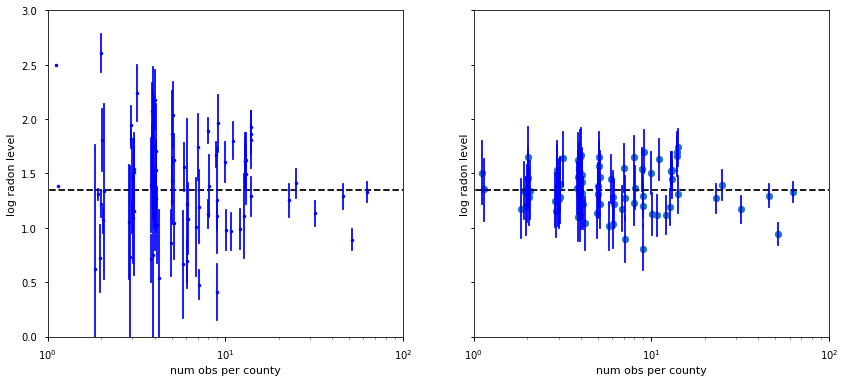

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True) # 1 by 2 plots
for axe in axes:
    axe.set_ylabel('log radon level')
    axe.set_xlabel('num obs per county')
    
# left plot is about the unpooled model
axes[0].plot(unpooled.n + jitter, unpooled.mean_j, 'b.')
        
for jit, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    axes[0].plot([dat.n + jit, dat.n+jit], [dat.mean_j - dat.se, dat.mean_j + dat.se], 'b-')
axes[0].set_xscale('log')
axes[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')


# right plot is the partial pooled model
samples, counties = sample_trace.shape
pp_means = sample_trace.mean(axis=0)
pp_sd    = sample_trace.std(axis=0)

axes[1].scatter(n_county.values + jitter, pp_means) # ploting the estimation and the se against the number of samples
axes[1].set_xscale('log')
axes[1].set_xlim(1,100)
axes[1].set_ylim(0, 3)
axes[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for jit, n, m, s in zip(jitter, n_county.values, means, sd):
    axes[1].plot([n+jit]*2, [m-s, m+s], 'b-')

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise.

## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [104]:
# a[J] below is a vector of 85 intercepts. All counties share slope beta though
varying_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
}
parameters {
  vector[J] a;
  real b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + x[i] * b;
}
model {
  sigma_a ~ uniform(0, 100);
  a ~ normal (mu_a, sigma_a);

  b ~ normal (0, 1);
  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [95]:
varying_intercept_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

varying_intercept_fit = pystan.stan(model_code=varying_intercept, data=varying_intercept_data, iter=500, chains=4)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5ae70772ae0d3782d483dfc90185c54a NOW.


In [96]:
# check out the fit results
varying_intercept_samples = varying_intercept_fit.extract(permuted=True)

# does sigma_a and sigma_y follow distributions? - yes they have hyper params samples, that were sampled from 
# our given distributions. Each of sigma_a and sigma_y have 4*500/2 = 1000 samples each
for k in varying_intercept_samples.keys():
    print(k, varying_intercept_samples[k].shape)

(u'a', (1000, 85))
(u'b', (1000,))
(u'mu_a', (1000,))
(u'sigma_a', (1000,))
(u'sigma_y', (1000,))
(u'y_hat', (1000, 919))
(u'lp__', (1000,))


In [105]:
a_sample = pd.DataFrame(varying_intercept_fit['a']) # this is the sampled intercepts
print(a_sample.shape)
a_sample.head() 

(1000, 85)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84
0,1.526201,1.033130,1.597251,1.839588,1.726262,1.729250,1.731234,1.691290,1.515146,1.577755,1.707400,1.372289,1.330027,2.028535,1.483767,1.004348,1.448711,1.282287,1.330805,1.836785,1.606672,1.336588,1.314576,1.716096,1.882369,1.305152,2.268915,1.542665,1.419645,1.235423,1.741216,1.699021,1.908960,1.493267,0.704716,2.038549,0.820312,1.500656,1.627373,1.558317,2.037844,1.820160,1.780238,1.219393,1.263238,1.205537,1.661456,1.520235,1.471231,1.845180,1.703359,1.421784,1.280663,1.276652,1.658161,0.700431,1.280425,1.478474,1.301629,1.338619,1.113650,1.668734,1.372769,1.837562,1.614961,1.470337,1.543916,0.765841,0.983436,0.833946,1.508772,1.435516,2.317032,1.411380,1.634908,1.499772,1.360754,1.219926,1.047966,1.354342,1.612503,2.223113,1.506350,1.860033,1.742879
1,1.445132,0.914971,1.951033,1.976599,1.107726,1.230171,1.679102,1.700954,1.036485,1.501662,1.489505,1.769828,1.234830,2.065920,1.607302,0.921019,1.379455,1.027047,1.489823,1.879538,2.075808,1.452446,1.297177,1.846602,1.715205,1.351511,1.717411,1.112044,1.677207,1.061493,1.971644,1.680814,1.744377,1.925584,1.108402,2.187860,0.820473,1.418171,1.836411,1.600885,1.639195,1.600969,1.790841,1.712376,1.478641,1.588873,1.398344,1.596851,1.687475,1.341098,2.085582,1.769916,0.976148,1.525712,1.246726,1.221829,0.951303,2.050236,1.573497,1.969906,1.342834,1.383534,1.563765,2.043873,1.858256,1.757773,1.830761,1.329413,1.370367,0.951182,1.632086,2.174286,1.564832,0.667214,2.036961,2.170493,1.604892,1.485033,1.109797,1.606454,1.884597,1.714986,1.892510,1.455021,1.634846
2,1.321007,0.884010,1.565449,1.740645,1.474109,1.714575,2.018890,1.521646,1.206906,1.299781,1.338037,1.494812,1.255240,1.971412,0.923663,1.030674,1.642968,1.310899,1.433318,1.544107,1.698763,1.243177,1.535628,1.732844,2.049883,1.244735,1.628416,1.270235,1.027905,1.132423,1.523423,1.283133,1.434800,1.452770,1.066017,1.652879,1.021744,1.366624,1.106032,1.820426,1.392510,1.442231,1.688584,0.860680,1.319762,1.651784,1.037000,1.219050,1.707380,1.481801,1.773046,1.471550,1.375454,1.336193,1.448005,0.855209,1.394660,1.451025,1.378333,1.208535,1.311441,1.831419,1.533243,1.494813,1.786469,1.682233,1.556504,1.443525,1.666497,0.960138,1.534276,1.691550,1.414032,1.479113,1.438673,1.623852,1.272052,1.221671,1.257930,1.766783,1.834218,1.736589,1.582848,1.382981,0.903187
3,1.814716,0.956116,1.667467,1.965450,1.353088,1.672012,1.745475,2.034011,1.236435,1.206219,1.036777,1.906122,1.324202,2.162636,1.844092,1.228234,1.436448,1.305070,1.327521,1.938625,1.376218,0.837466,1.330037,1.836848,1.794427,1.297929,1.840757,1.558415,1.575312,1.323870,1.610465,1.757786,1.935638,1.633593,1.097217,1.712008,0.658083,1.801834,1.699462,2.036576,1.702670,1.101316,1.470358,1.265694,1.172668,1.379080,1.066024,1.113845,1.716223,1.302637,1.809128,1.476082,1.200158,1.436894,1.914927,1.391782,1.064533,1.592747,1.860255,1.388952,1.219027,1.773559,1.878000,1.805035,1.243818,1.600237,1.741095,1.414579,1.222997,1.031945,1.710652,1.720246,1.888009,1.053876,1.861170,1.903824,1.936646,1.693327,1.410276,1.698616,1.935535,2.025077,1.842215,1.764969,1.516537
4,1.119854,1.014011,1.611041,1.538354,1.745646,1.890976,1.728924,1.847839,1.506327,1.634956,1.590862,1.771177,1.263234,1.468073,1.267424,1.301530,1.510273,1.572194,1.284581,2.106477,1.885861,1.527412,1.313340,2.114125,1.932592,1.373440,1.984975,1.359843,1.589653,1.178047,1.683750,1.787341,1.316191,1.746395,0.796802,2.037388,0.748360,1.331863,1.569738,1.645976,1.687313,1.901766,1.758312,1.178929,1.292991,1.185585,1.324132,1.313996,1.487932,1.987941,1.657327,1.399448,1.338835,1.304601,1.356810,1.846887,0.746694,1.496720,1.672928,1.203715,1.013336,1.602045,1.571013,1.856785,1.662568,1.494556,2.071329,1.097312,1.096023,0.822281,1.593547,1.537880,1.881859,1.212607,1.933784,1.837082,

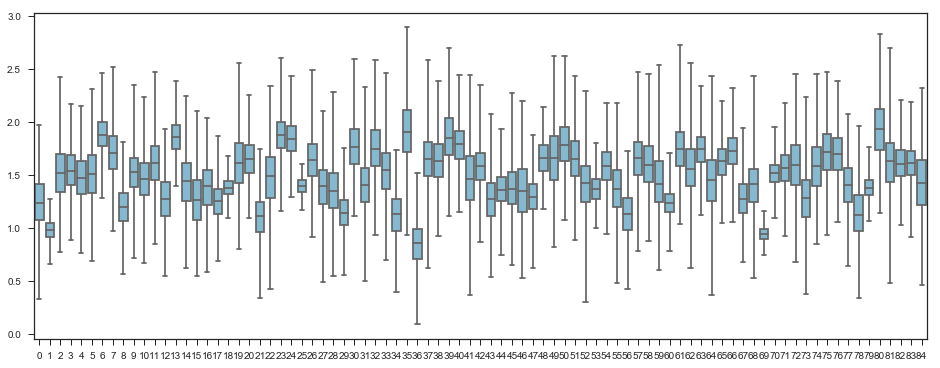

In [106]:
import seaborn as sns
sns.set(style="ticks", palette="muted", color_codes=True)

# Plot the orbital period with horizontal boxes
fig = plt.figure(figsize=(16, 6))
sns.boxplot(data=a_sample, whis=np.inf, color="c")
fig.axes[0]

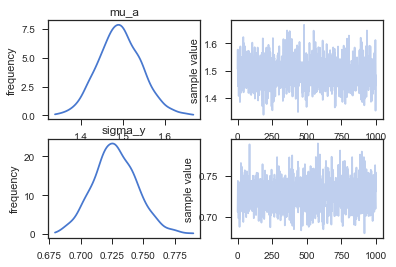

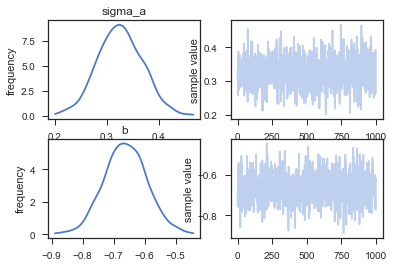

In [112]:
# the fit object from stan got plot method on them too - Visualize samples from posterior distributions
# varying_intercept_fit.plot.__doc__
varying_intercept_fit.plot(pars=['mu_a', 'sigma_y']);
varying_intercept_fit.plot(pars=['sigma_a', 'b']);

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

In [113]:
varying_intercept_fit['b'].mean()  # mean of the posterior distributions of beta (floor coef)

-0.6614194413927292

In [117]:
xvals = np.arange(2)
bp = varying_intercept_fit['a'].mean(axis=0)
mp = varying_intercept_fit['b'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1,1.1);

TypeError: object of type 'numpy.float64' has no len()

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

/home/nguyentu/anaconda3/envs/stan27/lib/python2.7/site-packages/pandas/core/series.py:705: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


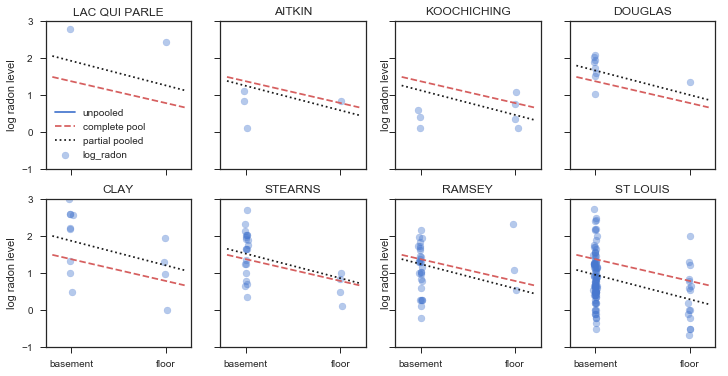

In [118]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
for i,c in enumerate(sample_counties):
    
    # Plot county data
    y = srrs_mn.log_radon[srrs_mn.county==c]
    x = srrs_mn.floor[srrs_mn.county==c]
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    m,b = unpooled_estimates[['floor', c]]
    
    xvals = np.linspace(-0.2, 1.2)
    # Unpooled estimate
    axes[i].plot(xvals, m*xvals+b, label='unpooled')
    # Pooled estimate
    axes[i].plot(xvals, m0*xvals+b0, 'r--', label='complete pool')
    # Partial pooling esimate
    axes[i].plot(xvals, mp*xvals+bp[county_lookup[c]], 'k:', label='partial pooled')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')
    if i == 0:
        axes[i].legend(loc='lower left')

## Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$


In [119]:
varying_slope = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] x;
  vector[N] y;
} 
parameters {
  real a;
  vector[J] b;
  real mu_b;
  real<lower=0,upper=100> sigma_b;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {

  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a + x[i] * b[county[i]];
}
model {
  sigma_b ~ uniform(0, 100);
  b ~ normal (mu_b, sigma_b);

  a ~ normal (0, 1);

  sigma_y ~ uniform(0, 100);
  y ~ normal(y_hat, sigma_y);
}
"""

In [121]:
varying_slope_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

varying_slope_fit = pystan.stan(model_code=varying_slope, data=varying_slope_data, iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_450bb1b9a4b2905be56a9a4fe472e0fd NOW.


In [122]:
b_sample = pd.DataFrame(varying_slope_fit['b'])

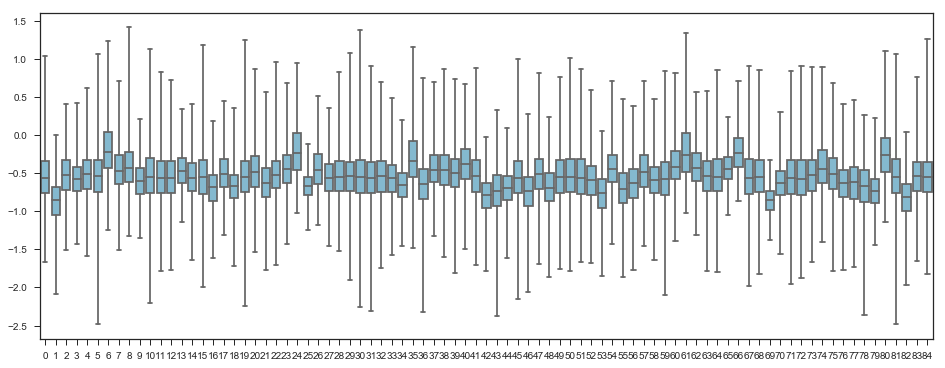

In [123]:
# Plot the orbital period with horizontal boxes
plt.figure(figsize=(16, 6))
sns.boxplot(data=b_sample, whis=np.inf, color="c")

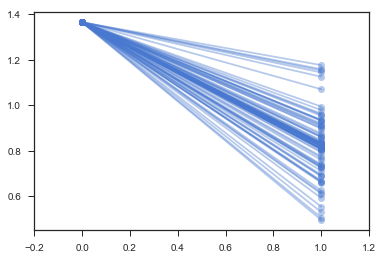

In [124]:
xvals = np.arange(2)
b = varying_slope_fit['a'].mean()
m = varying_slope_fit['b'].mean(axis=0)
for mi in m:
    plt.plot(xvals, mi*xvals + b, 'bo-', alpha=0.4)
plt.xlim(-0.2, 1.2);

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [125]:
varying_intercept_slope = """
data {
  int<lower=0> N;
  int<lower=0> J;
  vector[N] y;
  vector[N] x;
  int county[N];
}
parameters {
  real<lower=0> sigma;
  real<lower=0> sigma_a;
  real<lower=0> sigma_b;
  vector[J] a;
  vector[J] b;
  real mu_a;
  real mu_b;
}

model {
  mu_a ~ normal(0, 100);
  mu_b ~ normal(0, 100);

  a ~ normal(mu_a, sigma_a);
  b ~ normal(mu_b, sigma_b);
  y ~ normal(a[county] + b[county].*x, sigma);
}
"""

In [127]:
varying_intercept_slope_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'x': floor_measure,
                          'y': log_radon}

# This pystan.stan() is slow because it compile stan model into C++ code
varying_intercept_slope_fit = pystan.stan(model_code=varying_intercept_slope, 
                                          data=varying_intercept_slope_data, 
                                          iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_fb7a52c607796d20fe4b3a9a309cb1eb NOW.


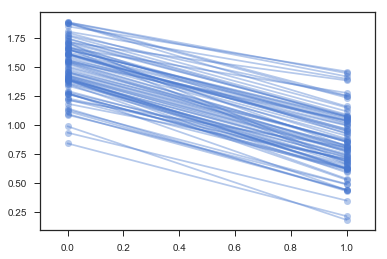

In [128]:
xvals = np.arange(2)
b = varying_intercept_slope_fit['a'].mean(axis=0)
m = varying_intercept_slope_fit['b'].mean(axis=0)
for bi,mi in zip(b,m):
    plt.plot(xvals, mi*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-0.1, 1.1);

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [129]:
hierarchical_intercept = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[2] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  vector[N] m;

  for (i in 1:N) {
    m[i] <- a[county[i]] + u[i] * b[1];
    y_hat[i] <- m[i] + x[i] * b[2];
  }
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

In [131]:
hierarchical_intercept_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'u': u,
                          'x': floor_measure,
                          'y': log_radon}

hierarchical_intercept_fit = pystan.stan(model_code=hierarchical_intercept, data=hierarchical_intercept_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_09c24493b150e61b5f7babd2ed515f09 NOW.


Text(0,0.5,'Intercept estimate')

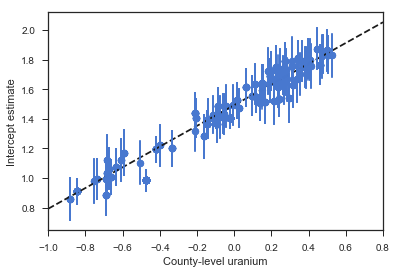

In [132]:
#a_means = M_hierarchical.a.trace().mean(axis=0)
m_means = hierarchical_intercept_fit['m'].mean(axis=0)
plt.scatter(u, m_means)
g0 = hierarchical_intercept_fit['mu_a'].mean()
g1 = hierarchical_intercept_fit['b'][:, 0].mean()
xvals = np.linspace(-1, 0.8)
plt.plot(xvals, g0+g1*xvals, 'k--')
plt.xlim(-1, 0.8)

m_se = hierarchical_intercept_fit['m'].std(axis=0)
for ui, m, se in zip(u, m_means, m_se):
    plt.plot([ui,ui], [m-se, m+se], 'b-')
plt.xlabel('County-level uranium'); plt.ylabel('Intercept estimate')

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [133]:
# Create new variable for mean of floor across counties
xbar = srrs_mn.groupby('county')['floor'].mean().rename(county_lookup).values

In [138]:
x_mean = xbar[counties]

In [139]:
contextual_effect = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + u[i]*b[1] + x[i]*b[2] + x_mean[i]*b[3];
}
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
"""

In [140]:
contextual_effect_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'u': u,
                          'x_mean': x_mean,
                          'x': floor_measure,
                          'y': log_radon}

contextual_effect_fit = pystan.stan(model_code=contextual_effect, data=contextual_effect_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b7928e9396770558600f70afccda0012 NOW.


In [141]:
contextual_effect_fit['b'].mean(0)

array([ 0.68712527, -0.68728995,  0.37392085])

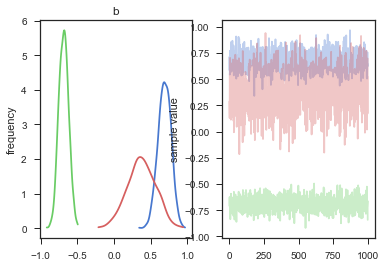

In [142]:
contextual_effect_fit.plot('b');

So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis county, we just need to sample from the radon model with the appropriate intercept.

In [143]:
county_lookup['ST LOUIS']

69

That is, 
$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

This is simply a matter of adding a single additional line in PyStan:

In [144]:
contextual_pred = """
data {
  int<lower=0> J; 
  int<lower=0> N; 
  int<lower=0,upper=J> stl;
  real u_stl;
  real xbar_stl;
  int<lower=1,upper=J> county[N];
  vector[N] u;
  vector[N] x;
  vector[N] x_mean;
  vector[N] y;
} 
parameters {
  vector[J] a;
  vector[3] b;
  real mu_a;
  real<lower=0,upper=100> sigma_a;
  real<lower=0,upper=100> sigma_y;
} 
transformed parameters {
  vector[N] y_hat;
  real stl_mu;

  for (i in 1:N)
    y_hat[i] <- a[county[i]] + u[i] * b[1] + x[i] * b[2] + x_mean[i] * b[3];
    
  stl_mu <- a[stl+1] + u_stl * b[1] + b[2] + xbar_stl * b[3];
 }
model {
  mu_a ~ normal(0, 1);
  a ~ normal(mu_a, sigma_a);
  b ~ normal(0, 1);
  y ~ normal(y_hat, sigma_y);
}
generated quantities {
  real y_stl;
  
  y_stl <- normal_rng(stl_mu, sigma_y);
}
"""

In [148]:
contextual_pred_data = {'N': len(log_radon),
                          'J': len(n_county),
                          'county': counties+1, # Stan counts starting at 1
                          'u': u,
                          'x_mean': x_mean,
                          'x': floor_measure,
                          'y': log_radon,
                          'stl': 69,
                          'u_stl': np.log(cty_mn[cty_mn.cty=='STLOUIS'].Uppm.values)[0],
                          'xbar_stl': xbar[69]}

In [149]:
contextual_pred_fit = pystan.stan(model_code=contextual_pred, data=contextual_pred_data, 
                                         iter=1000, chains=2)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e5df54feeaee9fa3eefb787ac27e9aa6 NOW.


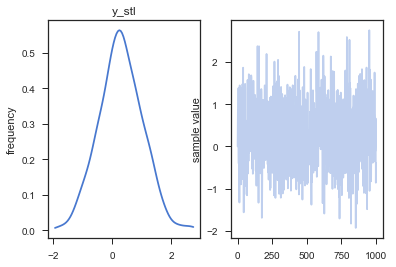

In [150]:
contextual_pred_fit.plot('y_stl');

## Exercise

How would we make a prediction from a new county (*e.g.* one not included in this dataset)?

In [151]:
# Write your answer here

## Benefits of Multilevel Models

Accounting for natural hierarchical structure of observational data

Estimation of coefficients for (under-represented) groups

Incorporating individual- and group-level information when estimating group-level coefficients

Allowing for variation among individual-level coefficients across groups



## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.